### 사용 데이터 셋
- Kaggle Image Classification data set : https://www.kaggle.com/puneet6060/intel-image-classification
- 150x150, 6 classes (buildings, forest, glacier, mountain, sea, street)
- seg_train / seg_test : 학습셋, 테스트셋 // seg_pred : 라벨링 안 되어있는 이미지 모음 ~ 모델 최종 예측값 확인
- 참고 : https://www.kaggle.com/trolukovich/vgg-like-87-accuracy-keras

## VGGNet
- keras api
- kernel 3x3 고정
- layer 깊이에 따른 모델 성능 확인 등등 조사 내용 추가

In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')
# 참고 사이트 : https://m.blog.naver.com/anne9/221798711142
#  내 드라이브 위치 : '/content/gdrive/My Drive/

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
# 함수형 api로 재구현
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
# 사용 데이터셋 읽기
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
#from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Dropout, AveragePooling2D
#from keras.layers import BatchNormalization, Flatten, LeakyReLU, DepthwiseConv2D
#from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix

In [ ]:
# 함수형 api로 재구성
image_input = Input(shape=(150,150,3)) # input_layer / 150x150xRGB
# block1
x = layers.Conv2D(64, 3, activation='relu', padding='same')(image_input) # block1_conv1 : Conv2D layer / 64_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x) # block1_conv2 : Conv2D layer / 64_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.MaxPooling2D(2, strides=2)(x) # block1_pool : MaxPooling2D layer / pool_size=2, stride=2 ~ 이미지 크기 (75,75)로 줄어듦음
# block2
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x) # block2_conv1 : Conv2D layer / 128_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x) # block2_conv2 : Conv2D layer / 128_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.MaxPooling2D(2, strides=2)(x) # block2_pool : MaxPooling2D layer / pool_size=2, stride=2 ~ 이미지 크기 (37,37)로 줄어듦음
# block3
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x) # block3_conv1 : Conv2D layer / 256_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x) # block3_conv2 : Conv2D layer / 256_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x) # block3_conv3 : Conv2D layer / 256_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.MaxPooling2D(2, strides=2)(x) # block3_pool : MaxPooling2D layer / pool_size=2, stride=2 ~ 이미지 크기 (18,18)로 줄어듦음
# block4 // 210122 : 필터 수 512에서 128로 변경
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x) # block4_conv1 : Conv2D layer / 512_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x) # block4_conv2 : Conv2D layer / 512_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x) # block4_conv3 : Conv2D layer / 512_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.MaxPooling2D(2, strides=2)(x) # block4_pool : MaxPooling2D layer / pool_size=2, stride=2 ~ 이미지 크기 (9,9)로 줄어듦음
# block5 // 210122 : 필터 수 512에서 64로 변경
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x) # block5_conv1 : Conv2D layer / 512_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x) # block5_conv2 : Conv2D layer / 512_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x) # block5_conv3 : Conv2D layer / 512_filter, kenel 3x3, 이미지 크기 변하지 않도록 same padding
x = layers.MaxPooling2D(2, strides=2)(x) # block5_pool : MaxPooling2D layer / pool_size=2, stride=2 ~ 이미지 크기 (4,4)로 줄어듦음
# fc 층 연결
x = layers.Flatten()(x) # fc층 이전 flatten
x = layers.Dense(1024, activation='relu')(x) # (4,4,512) -> 8192 => 4096 (절반) // 210122 : 1024로 변경
x = layers.Dense(512, activation='relu')(x) # 4096 => 2048 (절반) // 210122 : 512로 변경
output = layers.Dense(6, activation='softmax')(x) # 최종 클래스 6개

In [ ]:
model = Model(image_input, output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0     

In [ ]:
# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/vgg_practice_set/seg_train/seg_train', # 파일 위치 확인
                                                    target_size=(150,150), color_mode='rgb',
                                                    batch_size = 64, shuffle=True, seed = 2020,
                                                    class_mode='categorical', subset='training')

valid_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/vgg_practice_set/seg_train/seg_train', # 파일 위치 확인
                                                    target_size=(150,150), color_mode='rgb',
                                                    batch_size = 64, shuffle=True, seed = 2020,
                                                    class_mode='categorical', subset = 'validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/vgg_practice_set/seg_test/seg_test', # 파일 위치 확인
                                                  target_size=(150,150), color_mode='rgb',
                                                  batch_size=1, shuffle=False, seed = 2020,
                                                  class_mode=None) # test set setting check

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Found 9826 images belonging to 6 classes.
Found 4208 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
# callback 및 compile 설정
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/best_model.hdf5',
                             verbose = 1, monitor = 'val_accuracy', save_best_only = True) # verbose, monitor option check

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), # 0.00001 // 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(generator = train_generator,
                              epochs = 30,
                              steps_per_epoch = STEP_SIZE_TRAIN, # train_generator.n // train_generator.batch_size
                              validation_data=valid_generator,
                              callbacks = [checkpoint],
                              validation_steps = STEP_SIZE_VALID # valid_generator.n // valid_generator.batch_size
                              )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
153/153 [==============================] - 1198s 8s/step - loss: 1.7441 - accuracy: 0.2785 - val_loss: 1.2648 - val_accuracy: 0.5055

Epoch 00001: val_accuracy improved from -inf to 0.50553, saving model to /content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/best_model.hdf5
Epoch 2/30
153/153 [==============================] - 56s 368ms/step - loss: 1.1934 - accuracy: 0.5288 - val_loss: 1.1492 - val_accuracy: 0.5553

Epoch 00002: val_accuracy improved from 0.50553 to 0.55529, saving model to /content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/best_model.hdf5
Epoch 3/30
153/153 [==============================] - 55s 361ms/step - loss: 1.1152 - accuracy: 0.5705 - val_loss: 1.0424 - val_accuracy: 0.5978

Epoch 00003: val_accuracy improved from 0.55529 to 0.59784, saving model to /content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/best_model.hdf5
Epoch 4/30
153/153 [==============================] - 55s 362ms/step - loss: 1.0158 - accuracy: 0.6027 - val_loss: 0.99

Text(0.5, 1.0, 'loss')

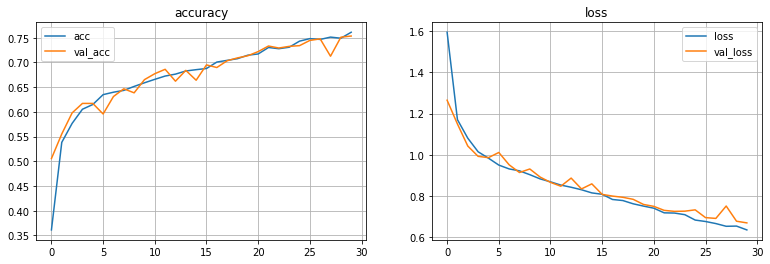

In [ ]:
# Accuracy/validation plots
h = history.history
fig = plt.figure(figsize = (13, 4))

plt.subplot(121)
plt.plot(h['accuracy'], label = 'acc')
plt.plot(h['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [ ]:
# Loading weights from best model
model.load_weights('/content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/best_model.hdf5')

# Saving all model
model.save('/content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/vgg_test_model_save.hdf5')

# Evaluate mmodel
evaluated = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
print(f'Best model loss: {round(evaluated[0], 2)}')
print(f'Best model accuracy: {round(evaluated[1] * 100, 2)}%')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Best model loss: 0.67
Best model accuracy: 75.29%


In [ ]:
# Predict classes in test dataset
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_generator.reset()
preds = model.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3000/3000 [==============================] - 1044s 348ms/step


In [ ]:
# Creating y_true and y_pred for confusion matrix
predicted_class_indices = np.argmax(preds, axis = 1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_pred = [labels[k] for k in predicted_class_indices]
y_true = [labels[k] for k in test_generator.labels]

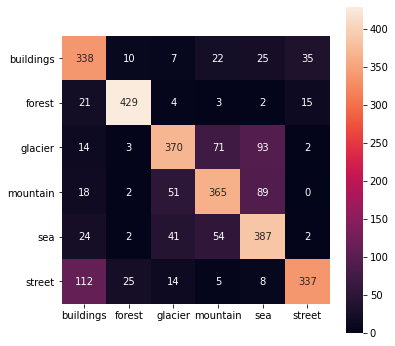

In [ ]:
# Plotting confusion matrix
l = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
confusion = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize = (6, 6))
sns.heatmap(confusion, annot = True, fmt = 'd', xticklabels = l, yticklabels = l, square = True)

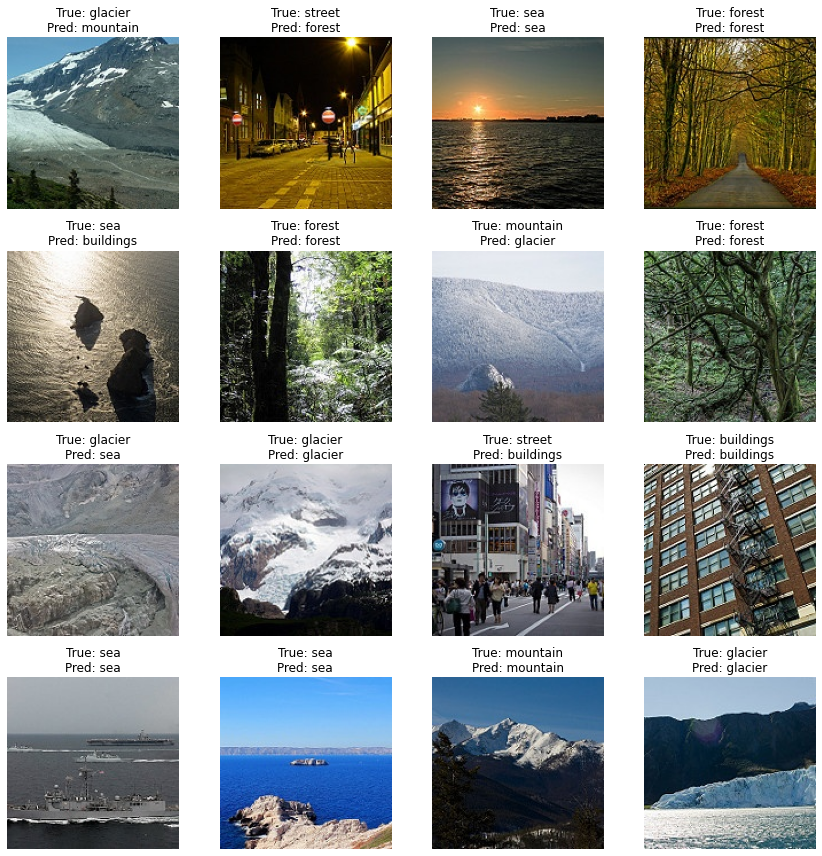

In [ ]:
# Showing examples of images with true and predicted classes
filenames = test_generator.filenames
rows, cols = (4, 4)

fig = plt.figure(figsize = (12, 12))
for i in range(rows * cols):
    r = np.random.randint(0, 2999)
    image_path = '/content/gdrive/MyDrive/vgg_practice_set/seg_test/seg_test' + '/' + filenames[r]
    image = cv.imread(image_path)
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image[:, :, ::-1])
    plt.title(f'True: {filenames[r].split("/")[0]}\nPred: {y_pred[r]}')
    plt.axis('off')

plt.tight_layout()

In [ ]:
for i in range(len(y_pred)):
  print("pred : ",y_pred[i], " // true : ",y_true[i])

pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  sea  // true :  buildings
pred :  mountain  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  street  // true :  buildings
pred :  buildings  // true :  buildings
pred :  buildings  // true :  buildings
pred :  street  // true :  buildings
pred :  street  // true :  buildings
pred :  street  